In [23]:
import os
import sys
import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import ast
from sklearn.ensemble import RandomForestRegressor
sys.path.insert(0, os.path.abspath("../../" + 'src/scraping'))
import metadata as meta
sys.path.insert(0, os.path.abspath("../../" + "src/modeling"))
import basic_stats as basic
import time
from PIL import Image

In [279]:
def get_all_thumbnails(save_dir, chan_ids, master_df):
    for chan_id in chan_ids:
        chan_df = master_df[master_df['channelId'] == chan_id]
        chan_vids = meta.download_df_thumbs(chan_df,save_dir,'medium')
    chan_basic_df = basic.basic_image_stats(save_dir)
    full_chan = master_df.merge(chan_basic_df,on='videoId')
    full_chan = full_chan.drop_duplicates(subset='videoId')
    return full_chan

def get_corr(img_feats, meta_feats,df,sign):
    corrs = []
    for col in meta_feats:
        for col2 in img_feats:
        #     col = 'z_views'
        #     col2 = 'contrast'
            step1 = df[df[col].notnull()]
            filtered = step1[step1[col2].notnull()]
            corr = np.corrcoef(filtered[col],filtered[col2])[0][1]
            corrs.append([col2, col, corr])
#             if sign == "-":
#                 if corr < 0:
#                     print(col, col2, corr)
#                     print('---------------')
#             else:
#                 if corr > 0:
#                     print(col, col2, corr)
#                     print('---------------')
    corr_df = pd.DataFrame(corrs, columns=['img_ft','meta_ft','corr'])
    return corr_df


# plots single emoition vs z views for all specified emotions
def get_emotions_df(emotions,in_df,meta_col):
    emotions_data = []
    for targ in emotions:
        emotion = in_df['emotions'].apply(lambda x: targ in x if type(x) == str else x)
        emotions_data.append(in_df[emotion == True][meta_col].describe())
    #     plt.scatter(emotion,face_data['z_views'])
    #     plt.title(targ + " vs. z_views")
    #     plt.xlabel(targ)
    #     plt.ylabel('z_views')
    #     plt.show()
    emotions_df = pd.DataFrame(emotions_data).reset_index()
    emotions_df['emotion'] = emotions
    return emotions_df
                    
def get_range(col_name, df):
    stats = df[col_name].describe()
    col_range = np.arange(stats['25%'],stats['max'],stats['std']/3)
    return col_range

def tune_params(df, c1, c2, meta_col):
    baseline_stats = df[meta_col].describe()
    base_mean = baseline_stats['mean']
    base_median = baseline_stats['50%']
#     print("baseline:     ",
#           "count:",baseline_stats['count'],
#           "mean:",baseline_stats['mean'].round(3),
#           "median:",baseline_stats['50%'].round(3))
    rel_stats = []
    c1_range = get_range(c1,df)
    c2_range = get_range(c2,df)
    for c1_cutoff in c1_range:
        for c2_cutoff in c2_range:
            filtered = df.apply(lambda x: x[c1] > c1_cutoff and x[c2] > c2_cutoff,axis=1)
            stats = df[filtered][meta_col].describe()
            cur_count = stats['count']
            cur_mean = stats['mean']
            cur_median = stats['50%']
            cur_stats_list = [c1,c1_cutoff,c2,c2_cutoff,cur_count, cur_mean, cur_median]
            rel_stats.append(cur_stats_list)
    res_df = pd.DataFrame(rel_stats, columns=['col1','col1cutoff','col2','col2cutoff','count','mean','median'])
    relevant_df = res_df[res_df['count'] > 0] # gets rid of param combinations with no results
    # filters out param combinations that did worse than the baseline
    better_df = relevant_df[relevant_df.apply(
        lambda x: x['mean'] > base_mean and x['median'] > base_median,axis=1)]
    return better_df

In [243]:
master_df = pd.read_csv("../../data/local/fortnite/video_data/fortnite_master_metadata_updated_facial_features.csv")
save_dir = "../../data/local/fortnite/thumbnails/"
chan_ids = all_meta['channelId'].value_counts().index

In [ ]:
final_df = get_all_thumbnails(save_dir, chan_ids, master_df)

In [244]:
final_df = final_df[final_df['z_views'].notnull()]
face_data = final_df[final_df['numFaces'].notnull()]
no_face_data = final_df[final_df['numFaces'].isnull()]
all_face = final_df.fillna(value={"numFaces":0})
analysis_df = all_face

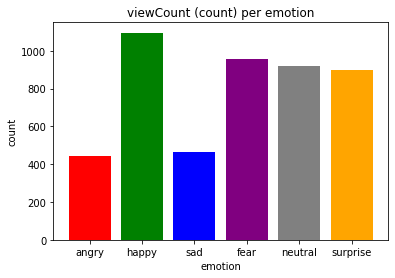

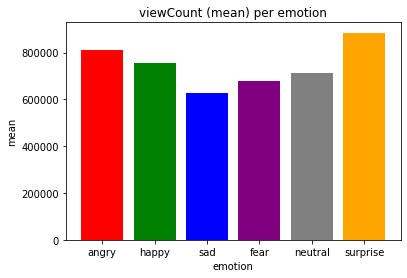

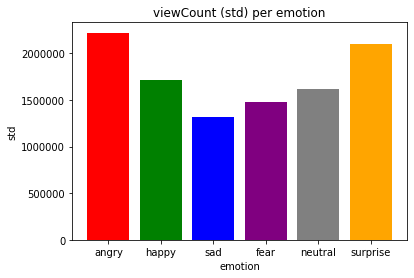

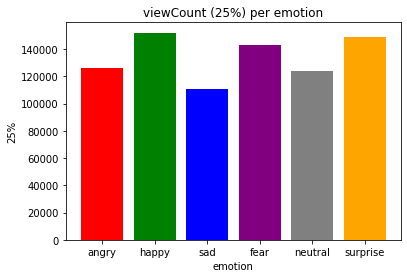

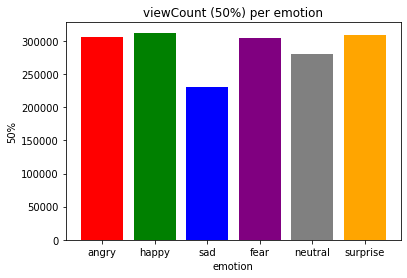

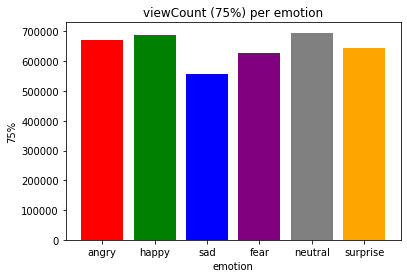

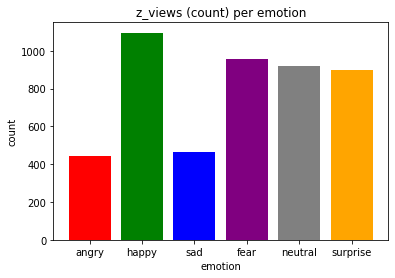

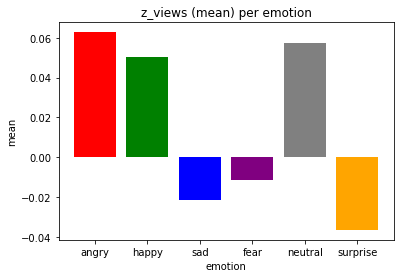

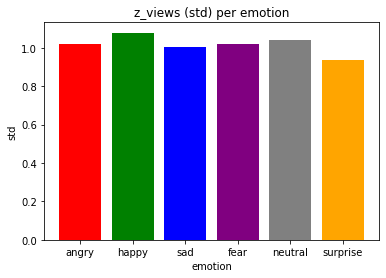

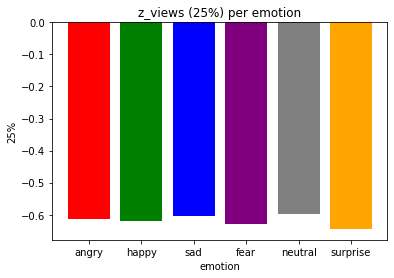

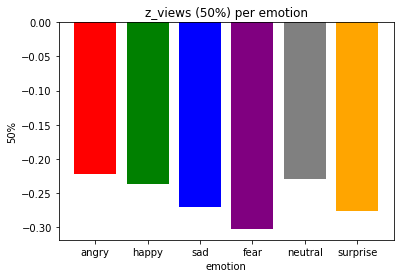

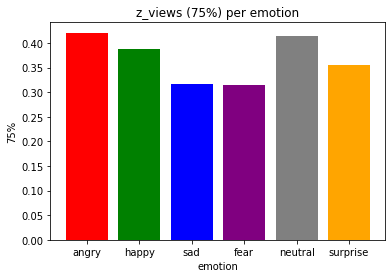

In [303]:
emotions = ['angry', 'happy', 'sad', 'fear', 'neutral', 'surprise']
describe_cols = ['count','mean','std','25%','50%','75%']
numerical_img_feats = ['unique_rgb_ratio','mean_hue',
                       'mean_saturation','mean_brightness', 'contrast',
                       'edge_score','numFaces']
meta_feats = ['viewCount','z_views']
# meta_col = None
for meta_feat in meta_feats:
    emotions_df = get_emotions_df(emotions,analysis_df,meta_feat)
    for col in describe_cols:
        plt.bar(emotions_df['emotion'],emotions_df[col],color=['red','green','blue','purple','grey','orange'])
        plt.xlabel('emotion')
        plt.ylabel(col)
        plt.title(meta_feat + " (" + col + ") per emotion")
        plt.show()

In [304]:
all_corrs = get_corr(numerical_img_feats, meta_feats, analysis_df, '-')
all_corrs

,img_ft,meta_ft,corr
0,unique_rgb_ratio,viewCount,-0.006591
1,mean_hue,viewCount,0.034842
2,mean_saturation,viewCount,-0.022539
3,mean_brightness,viewCount,0.054719
4,contrast,viewCount,-0.043900
5,edge_score,viewCount,-0.107582
6,numFaces,viewCount,0.035350
7,unique_rgb_ratio,z_views,0.044553
8,mean_hue,z_views,-0.010945
9,mean_saturation,z_views,0.026254


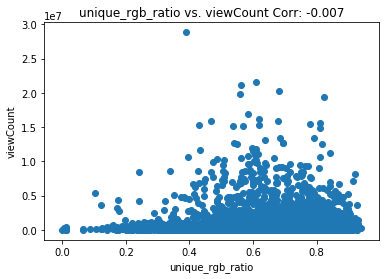

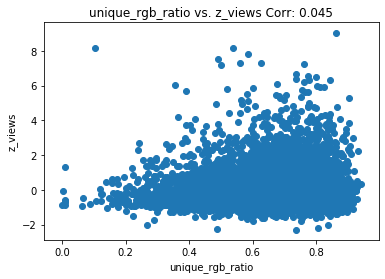

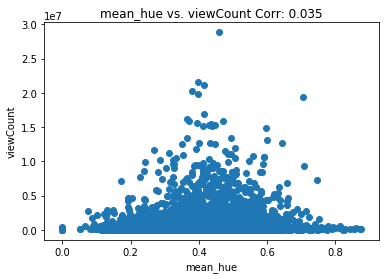

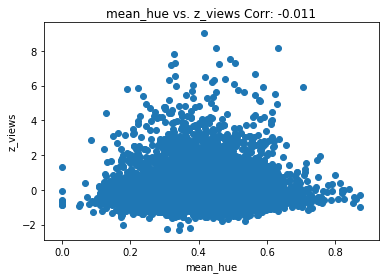

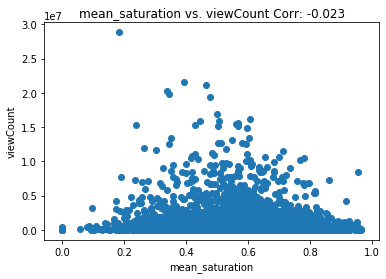

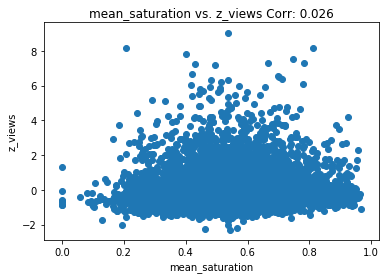

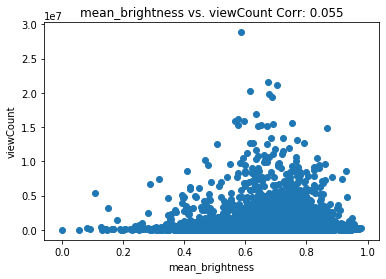

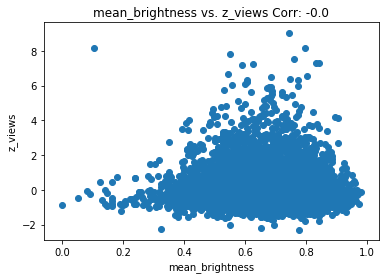

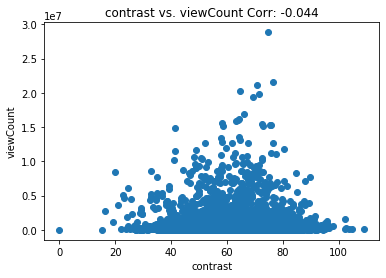

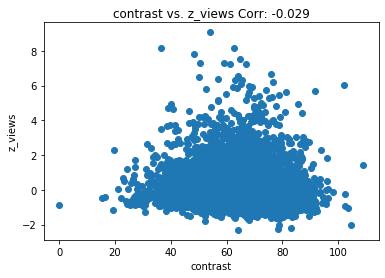

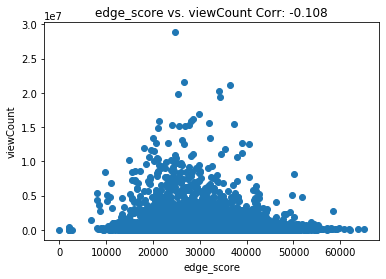

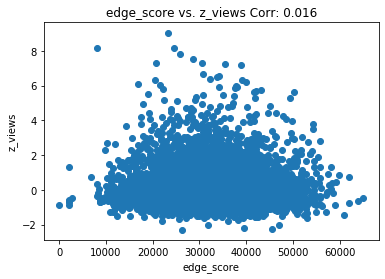

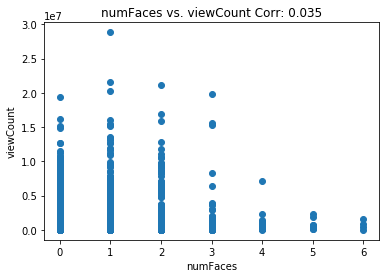

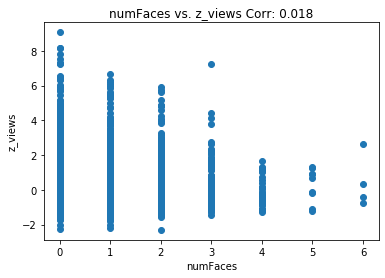

In [305]:
for col in numerical_img_feats:
    for meta_col in meta_feats:
        plt.scatter(analysis_df[col],analysis_df[meta_col])
        plt.xlabel(col)
        plt.ylabel(meta_col)
        cur_corr_df = all_corrs[all_corrs.apply(lambda x: x['img_ft'] == col and x['meta_ft'] == meta_col,axis=1)]
        cur_corr = cur_corr_df.iloc[0]['corr']
        plt.title(col + " vs. " + meta_col + " Corr: " + str(cur_corr.round(3)))
        plt.show()

In [306]:
summary_df = pd.DataFrame()
for meta_feat in meta_feats:
    cur_corr_df = all_corrs[all_corrs['meta_ft'] == meta_feat]
    c1, c2 = cur_corr_df.sort_values(by='corr',ascending=False)['img_ft'].iloc[0:2].values
    # this takes a while bc of the many combinations, may re-write the way I get the ranges
    tuned_df = tune_params(analysis_df,c1,c2,meta_feat) 
    tuned_df['mm_sum'] = tuned_df['mean'] + tuned_df['median']
    #old cell break
    top_df = tuned_df.sort_values(by='mm_sum',ascending=False)
    rgb_cutoff = top_df['col1cutoff'].describe()['mean']
    sat_cutoff = top_df['col2cutoff'].describe()['mean']
    top_cut = analysis_df[analysis_df.apply(
        lambda x: x[c1] > rgb_cutoff and x[c2] > sat_cutoff,axis=1)]

    baseline_stats = analysis_df[meta_feat].describe().round(4)
    baseline_stats['type'] = 'baseline'
    baseline_stats['meta_col'] = baseline_stats.name

    top_cut_stats = top_cut[meta_feat].describe().round(4)
    top_cut_stats['type'] = 'top_cut'
    top_cut_stats['meta_col'] = top_cut_stats.name

    cur_summary_df = pd.DataFrame([baseline_stats,top_cut_stats]).reset_index(drop=True)
    summary_df = pd.concat([summary_df,cur_summary_df])

In [307]:
summary_df

,count,mean,std,min,25%,50%,75%,max,type,meta_col
0,8688.0,6.863379e+05,1.466804e+06,1074.0000,113880.0000,265476.5000,6.315412e+05,2.883034e+07,baseline,viewCount
1,51.0,1.432502e+06,2.387187e+06,59477.0000,351153.0000,772097.0000,1.386452e+06,1.555928e+07,top_cut,viewCount
0,8688.0,-0.000000e+00,1.000100e+00,-2.2892,-0.6040,-0.2727,2.933000e-01,9.058700e+00,baseline,z_views
1,782.0,6.850000e-02,1.004300e+00,-1.3651,-0.6002,-0.1850,3.898000e-01,6.558300e+00,top_cut,z_views


In [288]:
# not adjusted for multiple meta feats
rf = RandomForestRegressor()
rf.fit(analysis_df[numerical_img_feats],analysis_df[[meta_col]])
feat_importances = pd.Series(dict(zip(numerical_img_feats,rf.feature_importances_)))
feat_importances.sort_values(ascending=False)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


mean_brightness     0.189695
edge_score          0.170062
mean_saturation     0.164789
unique_rgb_ratio    0.162381
contrast            0.148515
mean_hue            0.134118
numFaces            0.030440
dtype: float64

# Old

In [ ]:
# all_meta = pd.read_csv("../../data/local/fortnite/video_data/fortnite_master_metadata.csv")

In [ ]:
# big_df = pd.read_csv('../../data/local/fortnite/video_data/merged_df.csv').drop("Unnamed: 0",axis=1)

In [44]:
# no_faces = final_df[final_df['numFaces'].isnull()]['videoId']
# faces = final_df[final_df['numFaces'].notnull()]['videoId']

In [50]:
# for i in np.random.choice(len(faces),size=20):
#     display(Image.open("../../data/local/fortnite/thumbnails/" + faces.iloc[i] + ".jpg"))
#     print(final_df.iloc[i]['numFaces'])

In [51]:
# for i in np.random.choice(len(no_faces),size=20):
#     display(Image.open("../../data/local/fortnite/thumbnails/" + no_faces.iloc[i] + ".jpg"))

In [ ]:
# emotion = sorted_df['emotions'].apply(lambda x: len(ast.literal_eval(x)) if type(x) == str else 0)
# # print("Emotion:",targ)
# display(emotion.describe())
# plt.scatter(emotion,sorted_df['z_views'])
# # plt.show()

In [110]:
# numerical_img_feats = ['unique_rgb_ratio','num_rgb','mean_hue',
#                        'mean_saturation','mean_brightness', 'contrast',
#                        'edge_score','numFaces']
# meta_feats = ['z_views']

In [111]:
# get_corr(numerical_img_feats, meta_feats, face_data, '-')

In [112]:
# get_corr(numerical_img_feats, meta_feats, face_data, '+')

In [77]:
# c1 = 'num_rgb'
# c2 = 'edge_score'

In [108]:
# tuned_df = tune_params(face_data,c1,c2)
# tuned_df['mm_sum'] = tuned_df['mean'] + tuned_df['median']

In [109]:
# top_df = tuned_df.sort_values(by='mm_sum',ascending=False)
# rgb_cutoff = top_df['col1cutoff'].describe()['mean']
# sat_cutoff = top_df['col2cutoff'].describe()['mean']
# # face_data['z_views'].describe()
# top_cut = face_data[face_data.apply(
#     lambda x: x[c1] > rgb_cutoff and x[c2] > sat_cutoff,axis=1)]
# top_cut['z_views'].describe()

In [ ]:
# top_200 = pd.read_csv('../../data/local/fortnite/video_data/merged_df.csv').drop("Unnamed: 0",axis=1)
# full_views = top_200[top_200['z_views'].notnull()]

In [ ]:
# rf = RandomForestRegressor()
# rf.fit(full_views[basic_img_feats],full_views[['position']])
# rf.feature_importances_

In [ ]:
# baseline_stats = sorted_df['z_views'].describe()
# print("baseline:     ",
#       "count:",baseline_stats['count'],
#       "mean:",baseline_stats['mean'].round(3),
#       "median:",baseline_stats['50%'].round(3))
# # print('---------------------------------------')
# #['baseline',0,baseline_stats['count'],baseline_stats['mean'],baseline_stats['50%']]
# rel_stats = []
# c1 = 'num_rgb'
# c1_range = get_range(c1,sorted_df)
# c2 = 'mean_saturation'
# c2_range = get_range(c2, sorted_df)
# for c1_cutoff in c1_range:
#     for c2_cutoff in c2_range:
#         filtered = sorted_df.apply(lambda x: x[c1] > c1_cutoff and x[c2] > c2_cutoff,axis=1)
#         stats = sorted_df[filtered]['z_views'].describe()
#         cur_count = stats['count']
#         cur_mean = stats['mean']
#         cur_median = stats['50%']
#         cur_stats_list = [c1,c1_cutoff,c2,c2_cutoff,cur_count, cur_mean, cur_median]
#         rel_stats.append(cur_stats_list)
# res_df = pd.DataFrame(rel_stats, columns=['col1','col1cutoff','col2','col2cutoff','count','mean','median'])

In [ ]:
# not_null_df = res_df[res_df['mean'].notnull()]
# not_null_df[not_null_df.apply(lambda x: x['mean'] > .5 and x['median']> .2,axis=1)]

In [ ]:
# c1 = 'mean_saturation'
# c1_stats = sorted_df[c1].describe()
# c1_range = np.arange(c1_stats['25%'],c1_stats['75%'],c1_stats['std']/3)
# c1_range

In [ ]:
# col = 'contrast'
# print(sorted_df[col].describe())
# plt.scatter(sorted_df['contrast'],sorted_df['z_views'])

In [ ]:
# for vid_id in basic_stats_df['videoId'].values:
#     if vid_id not in df['videoId'].values:
#         print(vid_id)

In [ ]:
# merged_df = df.merge(basic_stats_df,how="left",on="videoId")

In [ ]:
# datetime.now().strftime("_%m_%d_%y")